# Decoder-only Transformers

In this section of the course we want to look at training our own Transformers. We provide you with an easy to follow and adapt workflow and show you the typical pitfals most blog posts and books do not mention.

Last session, we introduced the Encoder-only Transformer and this time we take a look at the Decoder-only Transformer to build a  model that can write book reviews given a prompt - e.g text to text.

## The Decoder-only Transformer

An Decoder Transformer esentially reads an entire text and predicts the next token. That means it "prolongs" an existing text. This might sound different than writing a review from a prompt but imagine the following text:

*We saw white sheep in New Zealand and England. There are white sheep in Germany and the Netherlands, too. Only in Canada we encountered a brown sheep. Therefore, we assume that*

How would you complete the sentence? Obviously there are many choices:

1.   *we should visit more places to see what color sheeps have there.*
2.   *most sheeps are white.*

Both options are highly conditioned on the prior text and that makes sense for a book review based on a prompt, too.

In 2018 (one year after "Attention is all you need") OpenAI released GPT2 as an Open Source model and the accompanying paper [Language Models are Unsupervised Multitask Learners](https://d4mucfpksywv.cloudfront.net/better-language-models/language_models_are_unsupervised_multitask_learners.pdf). This paper highlighted that Decoder-only models can be used to solve a wider range of tasks then specific Encoder-only models.

### The Decoder Data-Flow

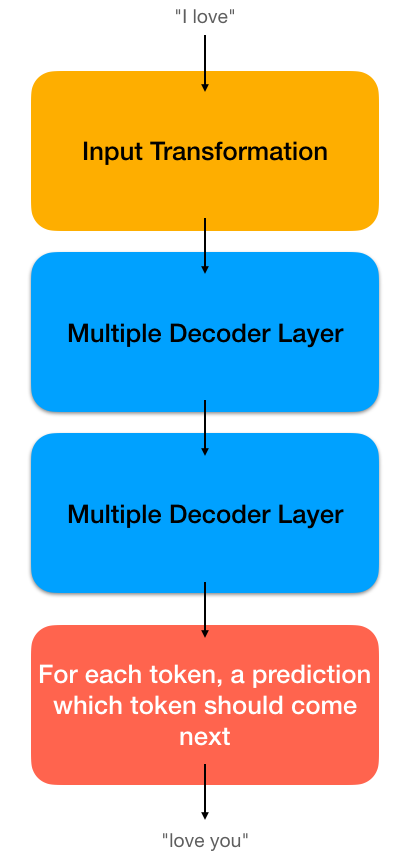

### The Input Transformation
Is exactly the same schema as for the Encoder only transfomer!

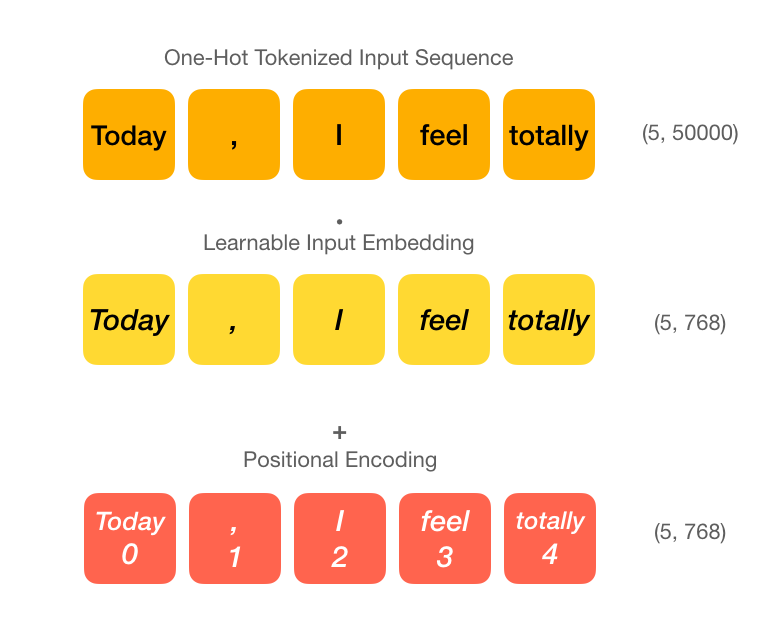

### The Decoder Layer(s)

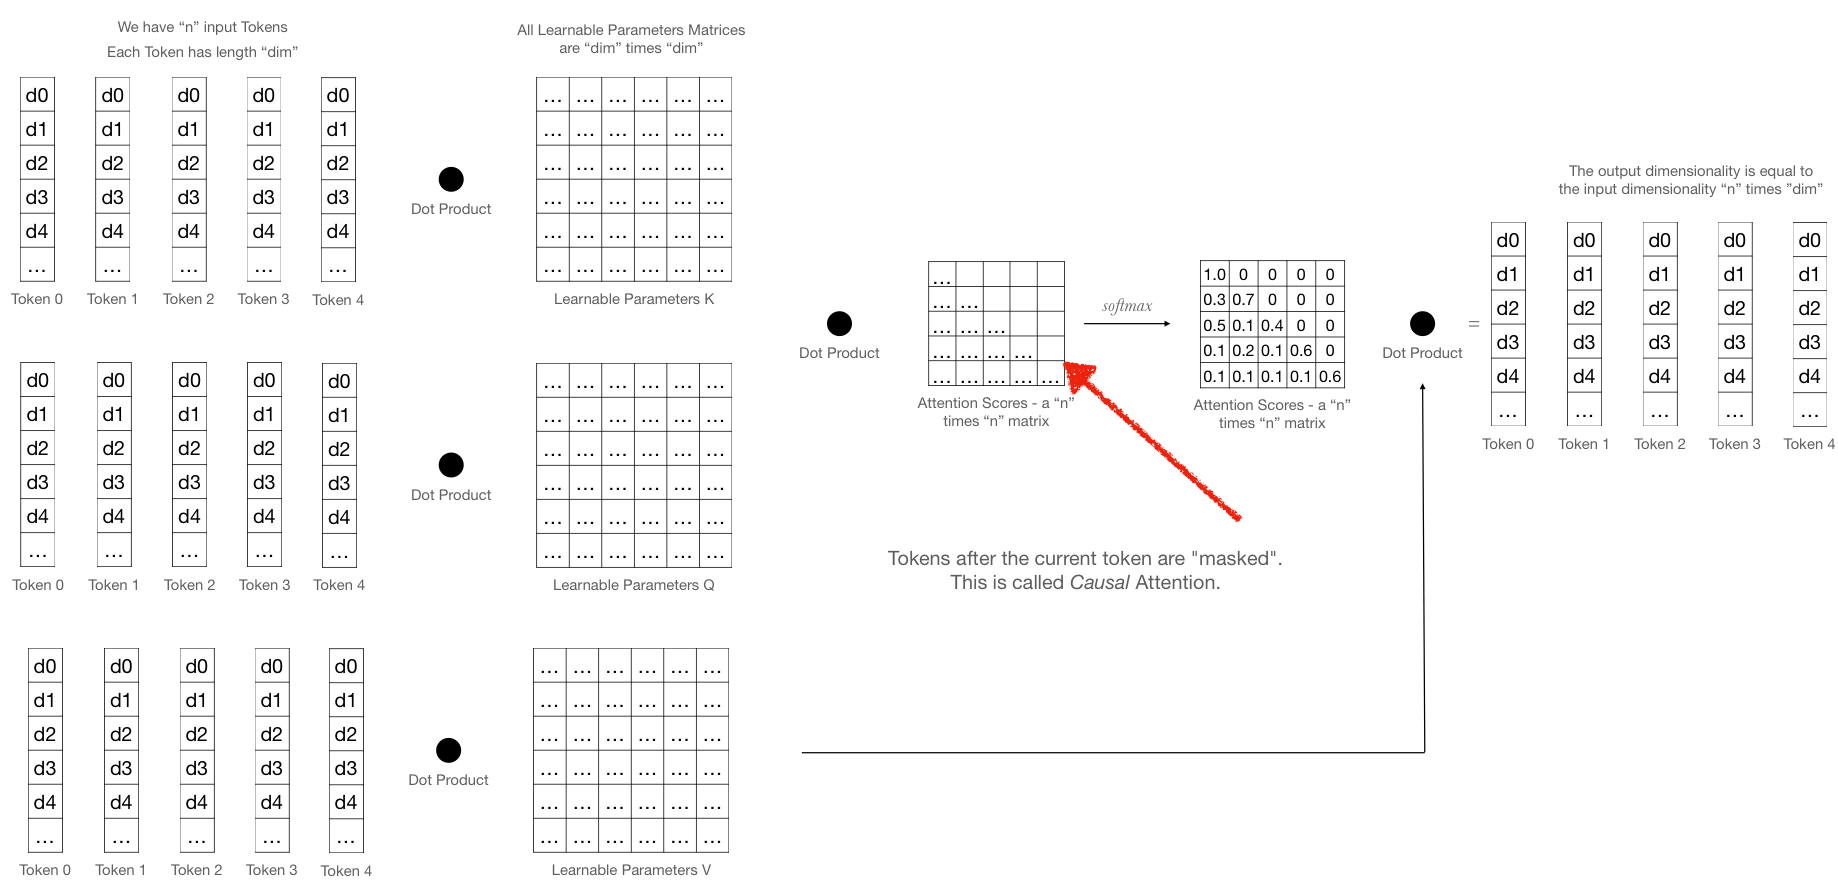

### Ouput Tasks

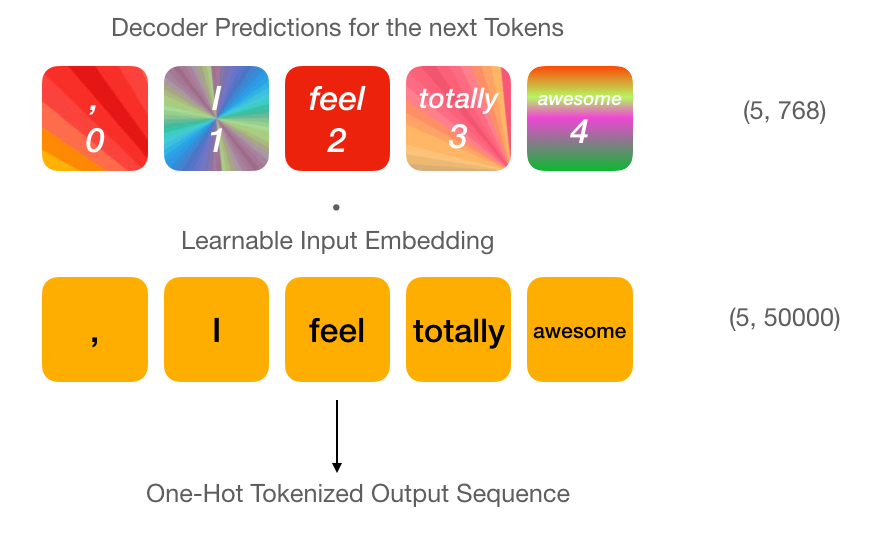

## Setup

In [ ]:
# Setup
# This cell installs all the dependencies used in this week - imports happen as we go
%%capture

!pip install transformers datasets accelerate python-dotenv openai tiktoken annoy

# Training and using a Decoder Transformer

Let's get started writing book reviews - we use the famous Amazon review dataset and reuse the cool streaming feature of the datasets objects introduced last session.

## Data Exploration - Create Your own Book reviews

In [ ]:
# Load the dataset and buffer the first 200 shuffled
from datasets import load_dataset


amazon_us_reviews = load_dataset("till0r/nlp-in-5-weeks-reviews", streaming=True, split='train')
shuffled_amazon_us_reviews = amazon_us_reviews.shuffle(seed=42, buffer_size=200)

In [ ]:
# We can use itertools again to gather the first n records from the streaming iterator
import itertools

N = 200
amazon_us_reviews_sample = list(itertools.islice(iter(shuffled_amazon_us_reviews), N))

In this section we want to show you how to convert a pandas DataFrame to a Huggingface Dataset. That might be handy for your daily work.

In [ ]:
import pandas as pd


df = pd.DataFrame(amazon_us_reviews_sample)
df

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,45232107,R3SJYLG07EHNE9,013146308X,332774292,The Pterosaurs: From Deep Time,Books,2.0,16.0,34.0,N,N,Warmed over leftovers,"To his discredit, Dr. Unwin virtually brags in...",2005-10-14
1,US,51197187,R10X8G16DAJH9R,0595368239,687973923,VAMPIRE: A sensual romance novella,Books,1.0,4.0,5.0,N,Y,Unpleasant Vampire Story,I must worn potential readers that the vampire...,2005-10-14
2,US,24577728,R30O48IC9RP08J,192904738X,469025369,13: Classical Baguazhang: Sun Style Baguazhang...,Books,5.0,4.0,5.0,N,N,A Great Translation of An Internal Martial Ar...,The author performs a great service in transla...,2005-10-14
3,US,49441053,R34X92SSRBI0N4,0966170229,396093604,PowerNomics : The National Plan to Empower Bla...,Books,5.0,26.0,29.0,N,N,Live on your feet or die on your knees,Mr. Andersons' book provides a thorough examin...,2005-10-14
4,US,12256167,R3NJ8RGXZRKKGQ,007142959X,822648026,The Successful Investor: What 80 Million Peopl...,Books,5.0,6.0,6.0,N,N,The Successful Investor - William J. O'Neil,This book was written for those who want to le...,2005-10-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,US,52960913,R1MZ3K8XOMPWEV,0525948775,535890305,The Death Collectors,Books,5.0,2.0,2.0,N,N,The resurrection of a long dead psychopath,"Jack Kerley's \\""The Death Collectors\\"" is a ...",2005-10-14
196,US,18755160,R1WIS16TAYHPP8,0515116475,437179605,Mallory's Oracle (A Mallory Novel),Books,5.0,1.0,3.0,N,N,Another Success,I started the series with Winter House and am ...,2005-10-14
197,US,51917717,R37OAEJ59YZR20,0385324162,390234841,A Breath of Snow and Ashes (Outlander),Books,4.0,6.0,12.0,N,N,Redeems the series,The Outlander series are my favorite books of ...,2005-10-14
198,US,23711977,R2Q6UPS8ILT1T,0061091316,56455717,Lost Boys,Books,4.0,3.0,3.0,N,N,A book that reveals the coplexities of everyda...,I read this book mulitiple times. The way Card...,2005-10-14


First, we need to design a prompt that is followed by the review.

In [ ]:
def create_prompt(row):
    return f"Write a {row['star_rating']} star review for {row['product_title']}: {row['review_body']}"

In [ ]:
# We can use Pandas apply to create a new column from create_prompt using existing columns
df["input"] = df.apply(create_prompt, axis=1)
df

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,input
0,US,45232107,R3SJYLG07EHNE9,013146308X,332774292,The Pterosaurs: From Deep Time,Books,2.0,16.0,34.0,N,N,Warmed over leftovers,"To his discredit, Dr. Unwin virtually brags in...",2005-10-14,Write a 2.0 star review for The Pterosaurs: Fr...
1,US,51197187,R10X8G16DAJH9R,0595368239,687973923,VAMPIRE: A sensual romance novella,Books,1.0,4.0,5.0,N,Y,Unpleasant Vampire Story,I must worn potential readers that the vampire...,2005-10-14,Write a 1.0 star review for VAMPIRE: A sensual...
2,US,24577728,R30O48IC9RP08J,192904738X,469025369,13: Classical Baguazhang: Sun Style Baguazhang...,Books,5.0,4.0,5.0,N,N,A Great Translation of An Internal Martial Ar...,The author performs a great service in transla...,2005-10-14,Write a 5.0 star review for 13: Classical Bagu...
3,US,49441053,R34X92SSRBI0N4,0966170229,396093604,PowerNomics : The National Plan to Empower Bla...,Books,5.0,26.0,29.0,N,N,Live on your feet or die on your knees,Mr. Andersons' book provides a thorough examin...,2005-10-14,Write a 5.0 star review for PowerNomics : The ...
4,US,12256167,R3NJ8RGXZRKKGQ,007142959X,822648026,The Successful Investor: What 80 Million Peopl...,Books,5.0,6.0,6.0,N,N,The Successful Investor - William J. O'Neil,This book was written for those who want to le...,2005-10-14,Write a 5.0 star review for The Successful Inv...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,US,52960913,R1MZ3K8XOMPWEV,0525948775,535890305,The Death Collectors,Books,5.0,2.0,2.0,N,N,The resurrection of a long dead psychopath,"Jack Kerley's \\""The Death Collectors\\"" is a ...",2005-10-14,Write a 5.0 star review for The Death Collecto...
196,US,18755160,R1WIS16TAYHPP8,0515116475,437179605,Mallory's Oracle (A Mallory Novel),Books,5.0,1.0,3.0,N,N,Another Success,I started the series with Winter House and am ...,2005-10-14,Write a 5.0 star review for Mallory's Oracle (...
197,US,51917717,R37OAEJ59YZR20,0385324162,390234841,A Breath of Snow and Ashes (Outlander),Books,4.0,6.0,12.0,N,N,Redeems the series,The Outlander series are my favorite books of ...,2005-10-14,Write a 4.0 star review for A Breath of Snow a...
198,US,23711977,R2Q6UPS8ILT1T,0061091316,56455717,Lost Boys,Books,4.0,3.0,3.0,N,N,A book that reveals the coplexities of everyda...,I read this book mulitiple times. The way Card...,2005-10-14,Write a 4.0 star review for Lost Boys: I read ...


As we have discuessed the Attention mechanism has a limited context length due to computational complexity and the trained positional encodings of a pretrained model would not exist for the new sequence positions.

If you train a model from scratch it is just a simple parameter - [see here for the config of GPT-2 in HuggingFace.](https://huggingface.co/docs/transformers/v4.26.1/en/model_doc/gpt2#transformers.GPT2Config) The parameter is called "n_positions".
[
Therefore, keeping an eye on the length of your texts is important.

<Axes: ylabel='Frequency'>

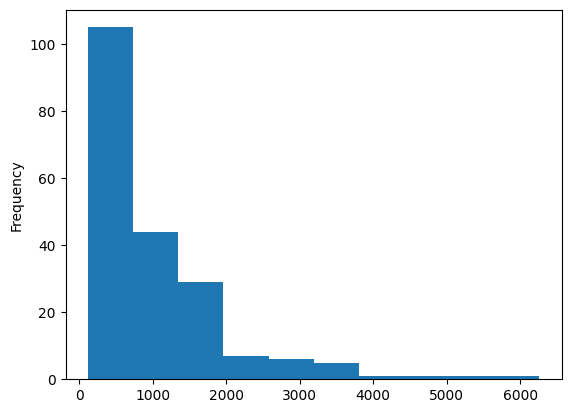

In [ ]:
# We have some very long reviews in this dataset
df["input"].str.len().plot.hist()

Let's imagine we have this dataset stored as a parquet file or need to store it. Pandas has built in Parquet support.

In [ ]:
# Write parquet
df.to_parquet("df.parquet")

In [ ]:
# Read parquet
df = pd.read_parquet("df.parquet")

#### Two ways to achive the same result

Now, we need to convert the DataFrame to a Huggingface dataset. There are two ways to achive exactly the same result here.

In [ ]:
# Option A - use a train-split defined somewehere else
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split

# Let's assume we have a given train-test split and therefore two Pandas DataFrames
train_df, valid_df = train_test_split(df, test_size=0.15, random_state=42)

# We can create two individual Huggingface Datasets
train_ds = Dataset.from_pandas(train_df)
valid_ds = Dataset.from_pandas(valid_df)

# And combine them to a DatasetDict
ds = DatasetDict()

ds['train'] = train_ds
ds['valid'] = valid_ds
ds

DatasetDict({
    train: Dataset({
        features: ['marketplace', 'customer_id', 'review_id', 'product_id', 'product_parent', 'product_title', 'product_category', 'star_rating', 'helpful_votes', 'total_votes', 'vine', 'verified_purchase', 'review_headline', 'review_body', 'review_date', 'input', '__index_level_0__'],
        num_rows: 170
    })
    valid: Dataset({
        features: ['marketplace', 'customer_id', 'review_id', 'product_id', 'product_parent', 'product_title', 'product_category', 'star_rating', 'helpful_votes', 'total_votes', 'vine', 'verified_purchase', 'review_headline', 'review_body', 'review_date', 'input', '__index_level_0__'],
        num_rows: 30
    })
})

In [ ]:
# Option B - we let Huggingface do the train-test-split
from datasets import Dataset

# This automatically created a DatasetDict
ds = Dataset.from_pandas(df).train_test_split(test_size=0.15)
ds

DatasetDict({
    train: Dataset({
        features: ['marketplace', 'customer_id', 'review_id', 'product_id', 'product_parent', 'product_title', 'product_category', 'star_rating', 'helpful_votes', 'total_votes', 'vine', 'verified_purchase', 'review_headline', 'review_body', 'review_date', 'input'],
        num_rows: 170
    })
    test: Dataset({
        features: ['marketplace', 'customer_id', 'review_id', 'product_id', 'product_parent', 'product_title', 'product_category', 'star_rating', 'helpful_votes', 'total_votes', 'vine', 'verified_purchase', 'review_headline', 'review_body', 'review_date', 'input'],
        num_rows: 30
    })
})

## Using a Decoder Transformer

You can read more about GPT-2 in [Language Models are Unsupervised Multitask Learners](https://d4mucfpksywv.cloudfront.net/better-language-models/language_models_are_unsupervised_multitask_learners.pdf), which is its accompanying paper.


In [ ]:
# Loading the Model and Tokenizer is as simple as with the Encoder models
from transformers import GPT2Tokenizer, GPT2LMHeadModel

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

# We have to pass this model a few extra parameters
model = GPT2LMHeadModel.from_pretrained("gpt2",
                                  bos_token_id=tokenizer.bos_token_id,
                                  eos_token_id=tokenizer.eos_token_id,
                                  scale_attn_by_inverse_layer_idx=True,
                                  reorder_and_upcast_attn=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
# Remember this code to see the size of a model
model_size = sum(t.numel() for t in model.parameters())
print(f"GPT-2 size: {model_size/1000**2:.1f} Million parameters")

GPT-2 size: 124.4 Million parameters


GPT-2 uses a different Encoder than BERT, but the idea is the same. Split parts of a word into tokens and maximze compression on the training dataset. With the GPT-2 BytePair Encoder the split does not happen on character, but on Unicode Byte Level.

In [ ]:
tokenizer(ds["train"][0]["review_body"])

{'input_ids': [12295, 587, 881, 329, 13226, 2106, 11, 475, 262, 3918, 11, 1449, 21319, 11, 290, 3572, 286, 2426, 2300, 1282, 1978, 845, 16576, 287, 428, 1492, 13], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

Byte-level BytePair Encoding is very powerful, because it can represent any text.

In [ ]:
tokenizer("🛒✈️")

{'input_ids': [8582, 249, 240, 26486, 230, 37929], 'attention_mask': [1, 1, 1, 1, 1, 1]}

Have you wondered how the model learns to stop predicting? There is a special Token for that. Note, that the Tokens of BERT and GPT-2 are not the same.

In [ ]:
# Can you spot the id of the <|endoftext|> token?
tokenizer(ds["train"][0]["review_body"] + '<|endoftext|>')

{'input_ids': [12295, 587, 881, 329, 13226, 2106, 11, 475, 262, 3918, 11, 1449, 21319, 11, 290, 3572, 286, 2426, 2300, 1282, 1978, 845, 16576, 287, 428, 1492, 13, 50256], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

To keep things fast in our limited time, we reduce the maximum length of the texts to 500 tokens.

In [ ]:
context_length = 500

It's a good practice to write a preprocessing function that does all the necessary changes to strings and tokens your usecase requires. Here we are truncating the encoded texts and add the <|endoftext|> token.

In [ ]:
def tokenize(element):
    outputs = tokenizer(
        [item + '<|endoftext|>' for item in element["input"]],
        truncation=True,
        max_length=context_length,
        return_overflowing_tokens=False,
        return_length=True
    )


    input_batch = []
    for length, input_ids in zip(outputs["length"], outputs["input_ids"]):
        input_batch.append(input_ids + [tokenizer.eos_token_id])


    return {"input_ids": input_batch}

Again, we use the Hugginface Dataset map method to tokenize all splits of the Dataset.

In [ ]:
tokenized_ds = ds.map(
    tokenize, batched=True, remove_columns=ds["train"].column_names
)

Map:   0%|          | 0/170 [00:00<?, ? examples/s]

Map:   0%|          | 0/30 [00:00<?, ? examples/s]

## Learn to Use the Hugging Face Trainer

If you thought there is no object from Huggingface coordinating the training you are wrong. The Huggingface Trainer is one of the best Training coordinators available and supports a huge range of options.

When using the Huggingface Trainer we need a Huggingface Data Collator that connects the Trainer to the Dataset. The Data Collator has two main jobs: Batch the Dataset and apply necessary functions to prepare the batch - like padding - e.g. adding special tokens to shorter sequences so that all sequences are the same length within a batch. This is necessay for GPU usage.


In [ ]:
# Of course there is a special Data Collator for exactly his task
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

In [ ]:
# Let's see the shapes of the first 5 records when run through the Data Collator
out = data_collator([tokenized_ds["train"][i] for i in range(5)])
for key in out:
    print(f"{key} shape: {out[key].shape}")

input_ids shape: torch.Size([5, 305])
attention_mask shape: torch.Size([5, 305])
labels shape: torch.Size([5, 305])


A Huggingface trainer needs Training Arguments that describe the Hyperparameters of the Training as well as the loss computation and all aspects of logging and saving of models. It even offers additional features that make training on multiple GPUs or smaller GPUs easier:



1.   Gradient Accumulation
2.   Multi GPU Usage via Distributed Data Parallel


Training a model on the full dataset might take a long time with Google Colab free tier. After this short training we will provide you with a way to load a model trained by us.

In [ ]:
from transformers import Trainer, TrainingArguments


args = TrainingArguments(
    output_dir="gpt2-book-reviews",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    evaluation_strategy="steps",
    eval_steps=6,
    logging_steps=6,
    gradient_accumulation_steps=8,
    num_train_epochs=4,
    weight_decay=0.1,
    warmup_steps=1_000,
    lr_scheduler_type="cosine",
    learning_rate=5e-4,
    save_steps=6,
    load_best_model_at_end=True,
    save_total_limit=4
    #fp16=True,
)

trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=args,
    data_collator=data_collator,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["test"]
)

In [ ]:
trainer.train(resume_from_checkpoint=False)

Step,Training Loss,Validation Loss
6,7.088900,6.461815
12,6.709500,6.111723
18,6.259900,5.611014


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


TrainOutput(global_step=20, training_loss=6.605344295501709, metrics={'train_runtime': 90.9354, 'train_samples_per_second': 7.478, 'train_steps_per_second': 0.22, 'total_flos': 124592410368000.0, 'train_loss': 6.605344295501709, 'epoch': 3.7209302325581395})

In [ ]:
# Let's try the results of this mini trainig
# First, we tokenize the prompt
tokenized = tokenizer("Write a 5 star review for Harry Potter and the sorcerer Stone:", return_tensors="pt")

# Then, we let the model run multiple times though the generate method until
# it encoutners a <|endoftext|> or reaches a deined max_length
generated =  model.generate(input_ids=tokenized["input_ids"].cuda(),
                            attention_mask=tokenized["attention_mask"].cuda(),
                            max_length=context_length, temperature=0.6,
                            encoder_no_repeat_ngram_size=3,
                            early_stopping=True,
                            do_sample=True)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [ ]:
# Now we just have to decode the tokens to characters
tokenizer.batch_decode(generated, skip_special_tokens=True)

["Write a 5 star review for Harry Potter and the sorcerer Stone: This is my first Potter book review ever, but I think it is the best. <br /> <br />I'm a huge Harry Potter fan, and I read all the Harry Potter books in the last 10 years.  I read all the Harry Potter books again in the last 10 years, and I'm just now getting into them, and they are all excellent.  I've read the whole series, and I've enjoyed them all, but they all seem to be the same...except for the fact that each book seems to have a different ending.  This book is different, but it is the same.  It doesn't have the same ending, and it doesn't have the same character. <br /> <br />The main differences are in the way the books are written.  There are brief descriptions of the usual things that happen (like potions, potions, and so on), but the main characters are written in very short, almost too short sentences.  This is a lot like a mood book, in that the main characters are very well developed, and the story is very 

In [ ]:
# If you want to, you can load our model here
model = GPT2LMHeadModel.from_pretrained("till0r/nlp-in-5-weeks-gpt2")
model = model.cuda()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/936 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/510M [00:00<?, ?B/s]

# Using OpenAI's API

In this section we will make use of OpenAI's API via their dedicated libray.

## Load an OpenAI API Key

In [ ]:
from dotenv import load_dotenv
import openai
import os

os.environ["OPENAI_API_KEY"] = ""


# Loads a file and dumps its context into the os environment variables
load_dotenv("env", override=True)

True

In [ ]:
from openai import OpenAI

client = OpenAI(max_retries=5)

# Emulating Week 2's classifier with OpenAI

## But first, let's do the embedding test!

In [ ]:
def get_embedding(text: str, model="text-embedding-3-small"):
    # replace newlines, which can negatively affect performance.
    text = text.replace("\n", " ")

    response = client.embeddings.create(input=[text], model=model)

    return response.data[0].embedding

In [ ]:
# One 1536 dimension vector per word ...
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

In [ ]:
# Let's create some embeddings
import numpy as np

queen_embedded = get_embedding("queen")
king_embedded = get_embedding("king")
cat_embedded = get_embedding("cat")
dog_embedded = get_embedding("dog")
tree_embedded = get_embedding("tree")
monkey_embedded = get_embedding("monkey")

In [ ]:
sub_space = np.vstack(
    [queen_embedded, king_embedded, cat_embedded,
     dog_embedded, tree_embedded, monkey_embedded]
    )

In [ ]:
# One 1536 dimension vector per word ...
sub_space.shape

(6, 1536)

In [ ]:
# ... turns into one 2 dimensional vector per word
redcued_sub_space = pca.fit_transform(sub_space)
redcued_sub_space.shape

(6, 2)

<Axes: >

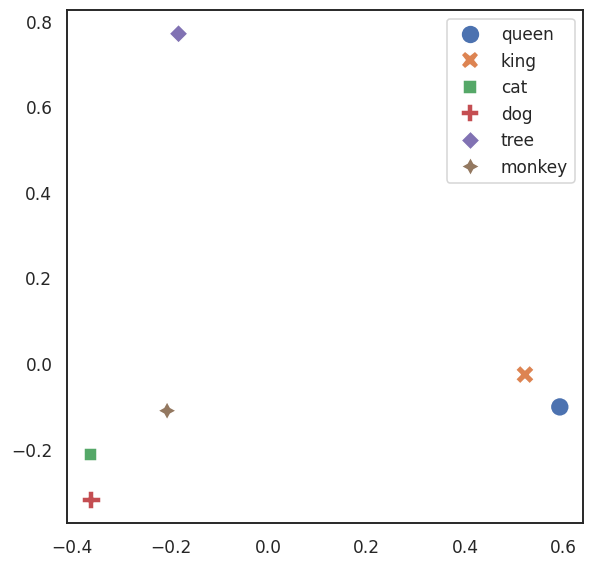

In [ ]:
# A scatter plot is the right choice to visualise the embedding space
import seaborn as sns


sns.set(style='white', context='notebook', rc={'figure.figsize':(6, 6), 'figure.dpi':111})

sns.scatterplot(x=redcued_sub_space[:, 0], y=redcued_sub_space[:, 1], s=150,
                style=["queen", "king", "cat", "dog", "tree", "monkey"],
                hue=["queen", "king", "cat", "dog", "tree", "monkey"])

## Zero-Shot Classification

In [ ]:
import numpy as np

def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [ ]:
# First let's embed our labels (hint, a neutral sentiment is a good idea in sentiment analysis)
labels = ['negative', 'positive']
label_embeddings = [get_embedding(label) for label in labels]

In [ ]:
def label_score(query_embedding, label_embeddings):
    # cosine similarity of the query embedding and the positive label minus the cosine similarity of the query embedding and the negative label
    criterium = cosine_similarity(query_embedding, label_embeddings[1]) - cosine_similarity(query_embedding, label_embeddings[0])

    return  'positive' if criterium > 0 else 'negative'

In [ ]:
query_embedding = get_embedding("Today, I feel totally awesome!")

label_score(query_embedding, label_embeddings)

'positive'

In [ ]:
query_embedding = get_embedding("It is raining - better take an umbrella or you will get wet!")

label_score(query_embedding, label_embeddings)

'negative'

# Generating Text with OpenAI's API

[See this page](https://platform.openai.com/docs/api-reference/chat/create) in the API's documentation for more details on the chat completion endpoints.

In [ ]:
response = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[
        {
        "role": "system",
        "content": "You will be provided with text, and your task is to translate it into emojis. Do not use any regular text. Do your best with emojis only."
        },
        {
        "role": "user",
        "content": "Artificial intelligence is a technology with great promise."
        }
    ],
    temperature=0.8,
    max_tokens=64,
    top_p=1,
    n=2
)

In [ ]:
response

ChatCompletion(id='chatcmpl-9OqkCqu9CHJsdUv9JXzAaBQvcQgIg', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='🤖💡👍', role='assistant', function_call=None, tool_calls=None)), Choice(finish_reason='stop', index=1, logprobs=None, message=ChatCompletionMessage(content='🤖💡👍', role='assistant', function_call=None, tool_calls=None))], created=1715709648, model='gpt-3.5-turbo-0125', object='chat.completion', system_fingerprint=None, usage=CompletionUsage(completion_tokens=16, prompt_tokens=52, total_tokens=68))

In [ ]:
response.choices[0].message.content, response.choices[1].message.content

('🤖💡👍', '🤖💡👍')

In [ ]:
response = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[
        {
        "role": "system",
        "content": "You will be provided with a block of text, and your task is to extract a list of keywords from it."
        },
        {
        "role": "user",
        "content": """The Artemis program is a Moon exploration program that is led by the United States' National Aeronoautics and Space Administration (NASA) and was formally established in 2017 via Space Policy Directive 1. The Artemis program is intended to reestablish a human presence on the Moon for the first time since the Apollo 17 moon mission in 1972. The program's stated long-term goal is to establish a permanent base on the Moon to facilitate human missions to Mars.
                        Two principal elements of the Artemis program are derived from the now-cancelled Constellation program: the Orion spacecraft and the Space Launch System (as a reincarnation of Ares V). Other elements of the program, such as the Lunar Gateway space station and the Human Landing System, are in development by government space agencies and private spaceflight companies. This collaboration is bound together by the Artemis Accords and governmental contracts.
                        The Space Launch System, Orion spacecraft and the Human Landing System form the main spaceflight infrastructure for Artemis, and the Lunar Gateway plays a supporting role in human habitation. Supporting infrastructures for Artemis include the Commercial Lunar Payload Services, VIPER rover, development of ground infrastructures, Artemis Base Camp on the Moon, Moon rovers and spacesuits. Some aspects of the program have been criticized, such as the use of a near-rectilinear halo orbit and the sustainability of the space program.
                        Orion's first launch on the Space Launch System was originally set in 2016, but faced numerous delays; it launched on 16 November 2022 as the Artemis 1 mission, with robots and mannequins aboard. According to plan, the crewed Artemis 2 launch is expected to take place in late 2025, the Artemis 3 crewed lunar landing is scheduled for late 2026, the Artemis 4 docking with the Lunar Gateway in late 2028, the Artemis 5 docking with the European Space Agency's ESPRIT, Canada's Canadarm3, and NASA's Lunar Terrain Vehicle in early 2030, and the Artemis 6 docking which is expected to integrate the Science Airlock with the Lunar Gateway station in early 2031. After Artemis 6, NASA expects yearly landings on the Moon to occur from then on."""
        }
    ],
    temperature=0.5,
    max_tokens=64,
    top_p=1
)

In [ ]:
print(response.choices[0].message.content)

Artemis program, Moon exploration, United States, National Aeronoautics and Space Administration, NASA, Space Policy Directive 1, human presence, Apollo 17, 1972, permanent base, Mars, Constellation program, Orion spacecraft, Space Launch System, Ares V, Lunar Gateway, Human Landing


# Putting it all together - RAG (Retrival Augmented Generation)

The RAG pattern is older then you might think - see the original papaer from 2020:

[Retrieval-Augmented Generation for Knowledge-Intensive NLP Tasks](https://arxiv.org/pdf/2005.11401.pdf)



Please download a Plain Text UTF-8 a copy of [The War of the Worlds by H. G. Wells](https://www.gutenberg.org/ebooks/36) and upload it to your Google Colab instance.


## Embedding the book

In [ ]:
# First, we need to read the text file

file_path = 'pg36.txt'
with open(file_path, 'r') as file:
    content = file.read()


print(f"The book has {len(content)} characters!")

The book has 356668 characters!


In [ ]:
# Second, let's chunk the book into windows of length - note the overlap

def chunk_text_by_characters_with_overlap(text, chars_per_chunk, overlap):
    start = 0
    while start < len(text):
        end = start + chars_per_chunk
        yield text[start:end]
        start = end - overlap  # move start up by chars_per_chunk minus the overlap

chunks = []
for chunk in chunk_text_by_characters_with_overlap(
    content,
    chars_per_chunk=3000,
    overlap=400):

    chunks.append(chunk)

print(f"We have {len(chunks)} chunks with a mean of {int(np.mean([len(chunk) for chunk in chunks]))} characters!")

We have 138 chunks with a mean of 2981 characters!


In [ ]:
# Now, let's embed these chunks with an OpenAI Embedding model

from tqdm import tqdm

embeddings = []

for chunk in tqdm(chunks):
    embeddings.append(get_embedding(chunk))

100%|██████████| 138/138 [00:31<00:00,  4.45it/s]


In [ ]:
len(embeddings[0])

1536

In [ ]:
from annoy import AnnoyIndex
from tqdm import tqdm


dim = 1536
unique_id = 0

# Setup the index
t = AnnoyIndex(dim, 'angular')


for embedding in embeddings:
    t.add_item(unique_id, embedding)
    unique_id += 1

t.build(10)
t.save('test.ann')

True

## Answer questions with knowledge from the book!

In [ ]:
# First, we embed our question to find the most relevant section in the book
# This is so much better then just using keywords

question = "What weapons do the invaders utilize?"
question_embedding = get_embedding(question)

In [ ]:
# Second, we retrieve the relevant chunk
result_idx = t.get_nns_by_vector(question_embedding, n=10)
result_idx

[57, 58, 128, 44, 77, 24, 62, 40, 86, 35]

In [ ]:
first_hit = result_idx[0]
print(chunks[first_hit])

other was
watching the fugitives stream over Westminster Bridge, that the
Martians had resumed the offensive. So far as one can ascertain from
the conflicting accounts that have been put forth, the majority of them
remained busied with preparations in the Horsell pit until nine that
night, hurrying on some operation that disengaged huge volumes of green
smoke.

But three certainly came out about eight o’clock and, advancing slowly
and cautiously, made their way through Byfleet and Pyrford towards
Ripley and Weybridge, and so came in sight of the expectant batteries
against the setting sun. These Martians did not advance in a body, but
in a line, each perhaps a mile and a half from his nearest fellow. They
communicated with one another by means of sirenlike howls, running up
and down the scale from one note to another.

It was this howling and firing of the guns at Ripley and St. George’s
Hill that we had heard at Upper Halliford. The Ripley gunners,
unseasoned artillery volunteers who 

In [ ]:
# Finally, assemble a conversation for the OpenAI chat API

In [ ]:
response = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[
        {
        "role": "system",
        "content": f"Answer the question based only on the following context: {chunks[first_hit]}"
        },
        {
        "role": "user",
        "content": question
        }
    ],
    temperature=0.5,
    max_tokens=64,
    top_p=1
)

In [ ]:
response.choices[0].message.content

'The invaders, Martians, utilize Heat-Rays as weapons. They also carry thick black tubes, which are likely some other type of weapon.'

# Summary


We hope you enjoyed this course - let's quickly recap what you have seen in these three weeks.



1.   A short recap of NLP history and the problems each "epoch" had
2.   Symbolic and Statistical methods to work with language
3.   How the idea of a word embedding changed everything
4.   How transformer models work on embeddings
5.   Encoder and Decoder transformers
6.   How a transformer can be task specific
7.   How generative transformers can work around task limitations through in context learning



# Where to go from here?



1.   **What is temperature?** You can play with temperature in the GPT2 example or OpenAI examples above. It is a very simple mechanism that shifts the propabilities of a model's output. This is done by manipulating the model's internal scores per class per token by simply dividing them by the temperature value (0 means no division). This way the higher the temperature the more random the next token becomes.
2.   **What are LoRA and QLoRA?** You might have heard about Low Rank Adapters or Quantized Low Rank Adapters in the context of fine-tuning larger Open Source models. In general these two aim to reduce the number of parameters that need to be trained and therefore memory consumption and compute needed by introducing new sets of parameters that can be "upscaled" for inference.
[See this link for more details on this topic.](https://lightning.ai/pages/community/lora-insights/)
3.   **How do I run LLama models on my computer?**
The fastest way to get up an runnining is [GPT4All](https://gpt4all.io/index.html) if you need a frontend or [ollama](https://github.com/ollama/ollama) if you want to build your own or get fancy. Both build on [llama.cpp](https://github.com/ggerganov/llama.cpp).
4.   **What is LangChain?** [LangChain](https://www.langchain.com/) is a controversial wrapper-framework that tries to bring common tools used with LLMs together in a simplified programming interface. I recommend you to use such tools directly to increase your understanding and make your solutions more flexible. Instead of following a LangChain tutorial, try finding a similar one in the [OpenAI Cookbook](https://cookbook.openai.com/).
5.   **How do I finetune smaller models?** As you saw in this week or follow the great [Natural Language Processing with Transformers](https://www.oreilly.com/library/view/natural-language-processing/9781098136789/) included in your Safari subscription.
6.   **How do I finetune bigger models?** This is a constantly changing topic - a good start is either the [Axolotl](https://github.com/OpenAccess-AI-Collective/axolotl) initative or the [HuggingFace Blog](https://huggingface.co/blog/ram-efficient-pytorch-fsdp).

